In [1]:
import numpy as np
import pandas as pd
import missingno as msn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import math

/home/harish/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# EDA and feature engineering

In [3]:
train_data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [4]:
train_data['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [5]:
train_data['Outlet_Size'].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [6]:
train_data['Outlet_Identifier'].unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

In [7]:
train_data['Outlet_Location_Type'].unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [8]:
train_data['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

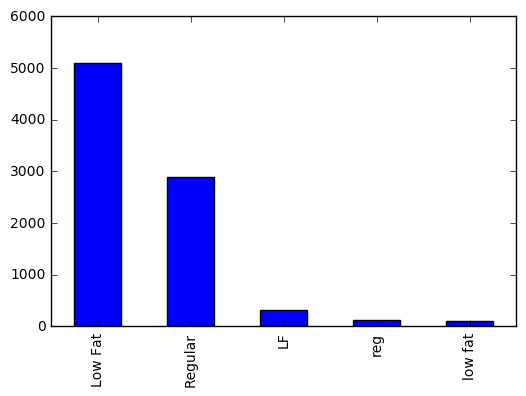

In [9]:
train_data['Item_Fat_Content'].value_counts().plot(kind = 'bar')

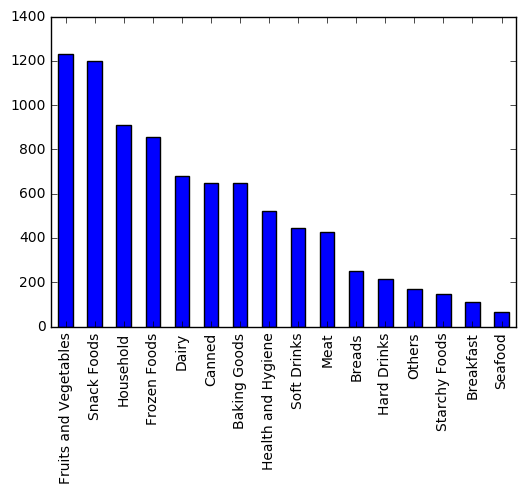

In [10]:
train_data['Item_Type'].value_counts().plot(kind = 'bar')

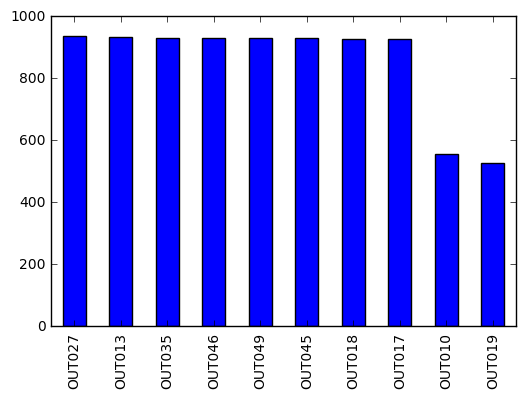

In [11]:
train_data['Outlet_Identifier'].value_counts().plot(kind = 'bar')

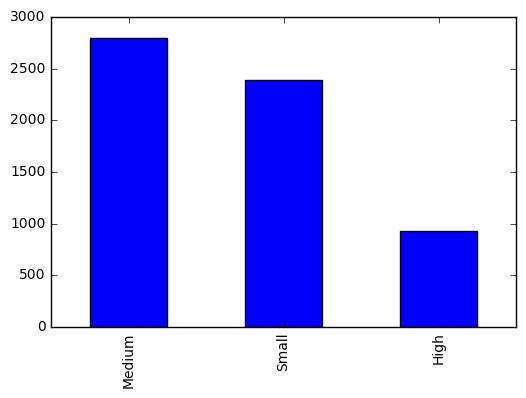

In [12]:
train_data['Outlet_Size'].value_counts().plot(kind = 'bar')

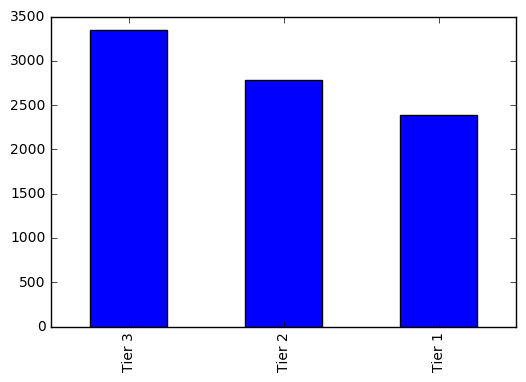

In [13]:
train_data['Outlet_Location_Type'].value_counts().plot(kind = 'bar')

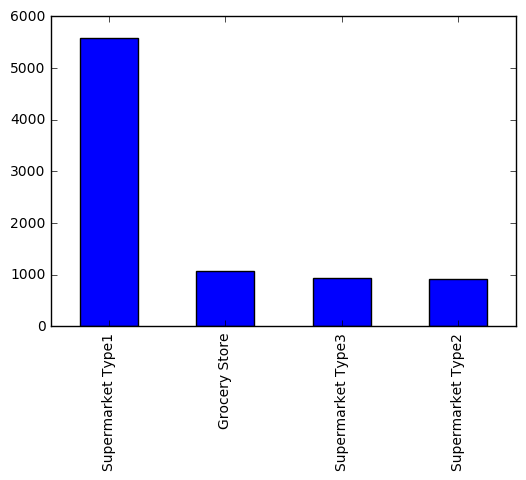

In [14]:
train_data['Outlet_Type'].value_counts().plot(kind = 'bar')

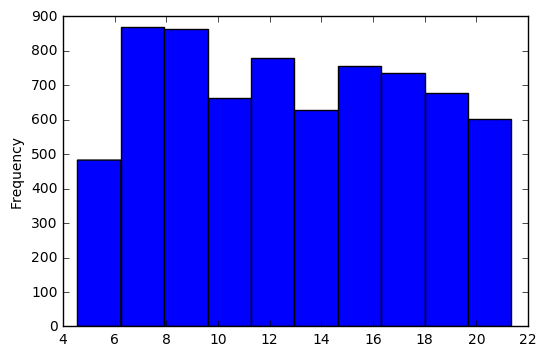

In [15]:
train_data['Item_Weight'].plot(kind = 'hist')

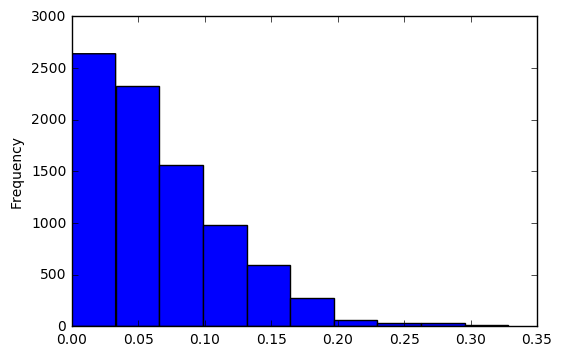

In [16]:
train_data['Item_Visibility'].plot(kind = 'hist')

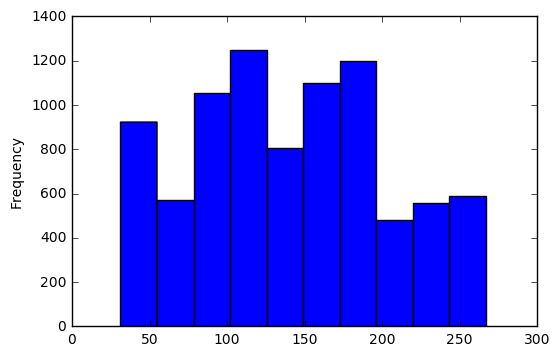

In [17]:
train_data['Item_MRP'].plot(kind = 'hist')

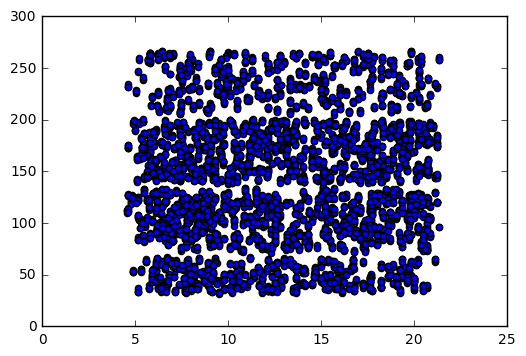

In [18]:
plt.scatter(train_data['Item_Weight'], train_data['Item_MRP'])
plt.show()

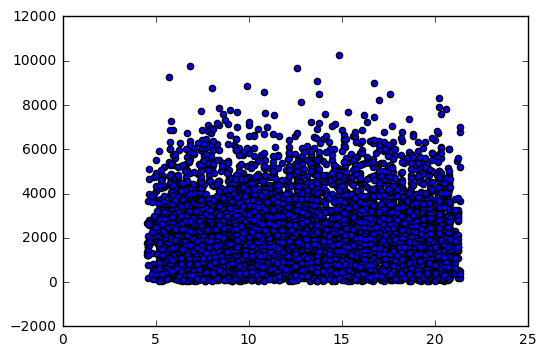

In [19]:
plt.scatter(train_data['Item_Weight'], train_data['Item_Outlet_Sales'])
plt.show()

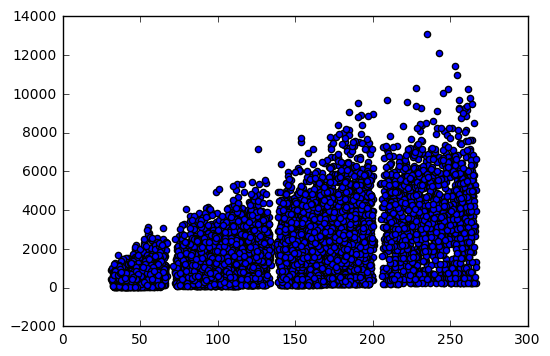

In [20]:
plt.scatter(train_data['Item_MRP'], train_data['Item_Outlet_Sales'])
plt.show()

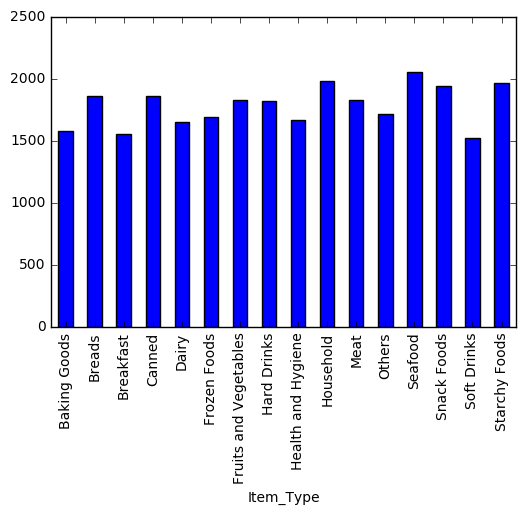

In [21]:
train_data.groupby('Item_Type')['Item_Outlet_Sales'].median().plot(kind = 'bar')

In [22]:
train_data['Item_Fat_Content'].replace(train_data['Item_Fat_Content'].unique(), [2, 1, 2, 2, 1], inplace = True)
test_data['Item_Fat_Content'].replace(test_data['Item_Fat_Content'].unique(), [2, 1, 2, 2, 1], inplace = True)

In [23]:
train_data['Outlet_Size'].replace(['Small', 'Medium', 'High'], [1, 2, 3], inplace = True)
test_data['Outlet_Size'].replace(['Small', 'Medium', 'High'], [1, 2, 3], inplace = True)

In [24]:
train_data['Outlet_Location_Type'].replace(['Tier 1', 'Tier 2', 'Tier 3'], [1, 2, 3], inplace = True)
test_data['Outlet_Location_Type'].replace(['Tier 1', 'Tier 2', 'Tier 3'], [1, 2, 3], inplace = True)

In [25]:
train_data['Outlet_Establishment_Year'] = train_data['Outlet_Establishment_Year'] - train_data['Outlet_Establishment_Year'].median()
test_data['Outlet_Establishment_Year'] = test_data['Outlet_Establishment_Year'] - test_data['Outlet_Establishment_Year'].median()

In [26]:
train_data['Item_Visibility'] = train_data['Item_Visibility'] + 0.1
test_data['Item_Visibility'] = test_data['Item_Visibility'] + 0.1

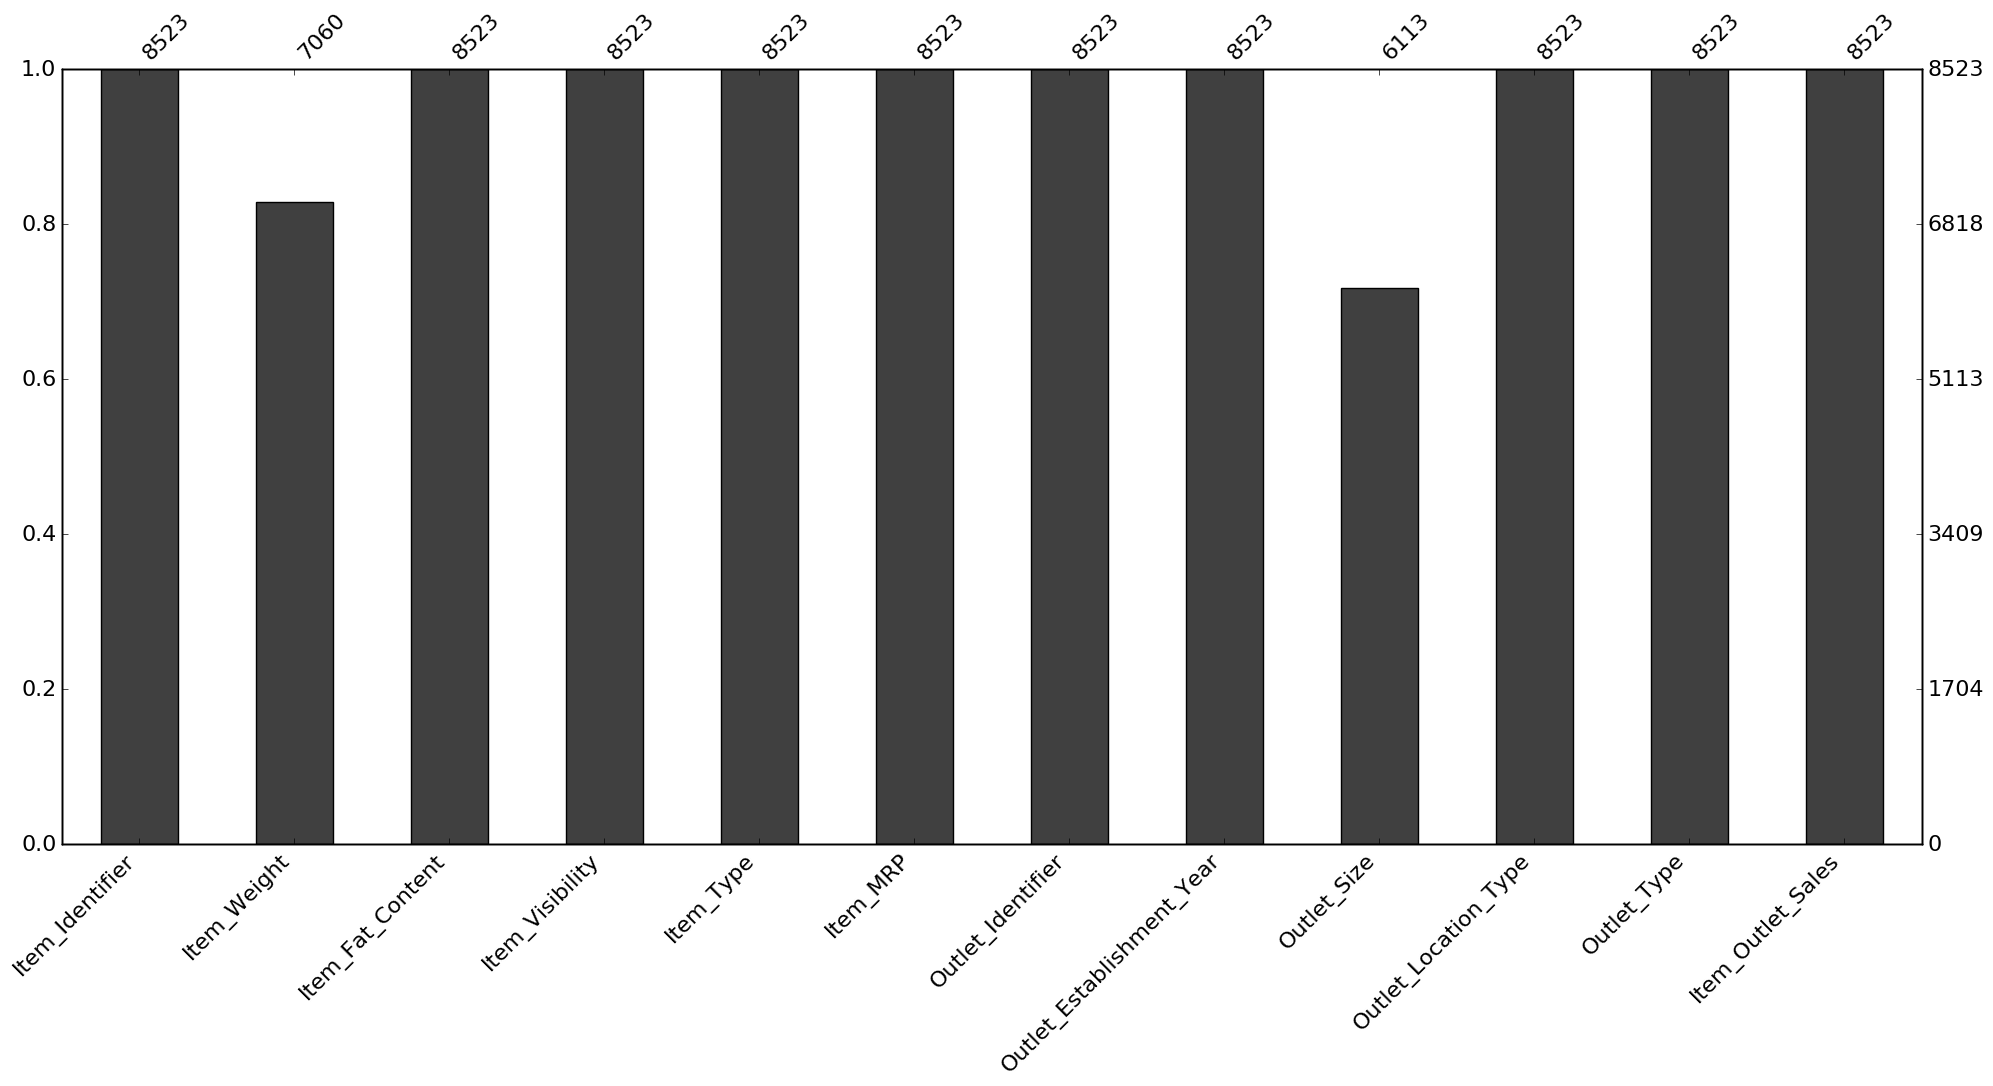

In [27]:
msn.bar(train_data)

In [28]:
train_data['Outlet_Size'] = np.where(train_data['Outlet_Size'].isnull(), 
                                     train_data['Outlet_Size'].mode(), 
                                     train_data['Outlet_Size'])
train_data['Item_Weight'] = np.where(train_data['Item_Weight'].isnull(), 
                                     train_data['Item_Weight'].mean(), 
                                     train_data['Item_Weight'])
test_data['Outlet_Size'] = np.where(test_data['Outlet_Size'].isnull(), 
                                     test_data['Outlet_Size'].mode(), 
                                     test_data['Outlet_Size'])
test_data['Item_Weight'] = np.where(test_data['Item_Weight'].isnull(), 
                                     test_data['Item_Weight'].mean(), 
                                     test_data['Item_Weight'])

In [29]:
train_data.drop(['Item_Identifier', 'Item_Type'], axis = 1, inplace = True)
pred_df = test_data[['Item_Identifier', 'Outlet_Identifier']]
test_data.drop(['Item_Identifier', 'Item_Type'], axis = 1, inplace = True)

In [30]:
train_data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,2,0.116047,249.8092,OUT049,0.0,2.0,1,Supermarket Type1,3735.1380
1,5.92,1,0.119278,48.2692,OUT018,10.0,2.0,3,Supermarket Type2,443.4228
2,17.50,2,0.116760,141.6180,OUT049,0.0,2.0,1,Supermarket Type1,2097.2700
3,19.20,1,0.100000,182.0950,OUT010,-1.0,2.0,3,Grocery Store,732.3800
4,8.93,2,0.100000,53.8614,OUT013,-12.0,3.0,3,Supermarket Type1,994.7052


In [31]:
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:,0:9], 
                                                    train_data.iloc[:,9], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [32]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
test_data = pd.get_dummies(test_data)

# Iteration 1: Using ridge regression

In [33]:
clf = Ridge(alpha = 1.0)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
math.sqrt(mean_squared_error(y_test, prediction))

1067.3150709323925

In [34]:
test_prediction = clf.predict(test_data)
pred_df['Item_Outlet_Sales'] = test_prediction
pred_df.to_csv("./bigmart_sales_prediction.csv")

# Iteration 2: Using random forest regressor

In [42]:
clf = RandomForestRegressor(oob_score = True,
                            random_state = 42
                           )

parameters = {'n_estimators': [1000, 1200], 
              'max_features': ['auto', 'sqrt'], 
              'criterion': ['mse'],
              'max_depth': [5], 
              'min_samples_split': [2],
              'min_samples_leaf': [11, 12]
             }
grid_search = GridSearchCV(clf, parameters)
grid_search.fit(X_train, y_train)
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
math.sqrt(mean_squared_error(y_test, prediction))

1019.313108079556

In [36]:
test_prediction = clf.predict(test_data)
pred_df['Item_Outlet_Sales'] = test_prediction
pred_df.to_csv("./bigmart_sales_prediction.csv")

In [37]:
grid_search.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 11,
 'min_samples_split': 2,
 'n_estimators': 1200}

# Iteration 3: Using XGBoost Regressor

In [38]:
clf = XGBRegressor(max_depth = 3, n_estimators = 500)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
math.sqrt(mean_squared_error(y_test, prediction))

1063.2911964937773

In [39]:
test_prediction = clf.predict(test_data)
pred_df['Item_Outlet_Sales'] = test_prediction
# pred_df.to_csv("./bigmart_sales_prediction.csv")

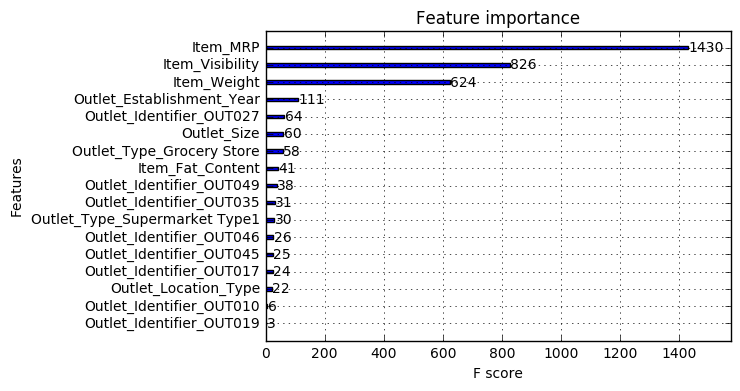

In [40]:
xgboost.plot_importance(clf)

# Iteration 4: Using Adaboost regressor

In [53]:
dt_rgr = DecisionTreeRegressor(max_depth = 6, max_features = 'auto', min_samples_leaf = 2, random_state = 42)
ada_rgr = AdaBoostRegressor(dt_rgr, loss = 'exponential', n_estimators = 64, learning_rate = 0.05, random_state = 42)
ada_rgr.fit(X_train, y_train)
prediction = ada_rgr.predict(X_test)
math.sqrt(mean_squared_error(y_test, prediction))

1022.5780401814274

In [54]:
test_prediction = ada_rgr.predict(test_data)
pred_df['Item_Outlet_Sales'] = test_prediction
pred_df.to_csv("./bigmart_sales_prediction.csv")